#Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import sys
sys.path.insert(0, '..')

# Implementing a Base Cellular Automata (the game of life)

In [ ]:
#create a cellular automata with certain ruleset and return as Tensor
radius = 3

neighbor_filter = np.ones((radius, radius))
neighbor_filter[1,1] = 0
middle_filter = np.zeros((radius, radius))
middle_filter[1,1] = 1
all_filters = np.dstack((middle_filter, neighbor_filter, neighbor_filter, neighbor_filter, neighbor_filter))
all_biases = np.array([0,  -1, -2, -3, -4]) 
total_filters = len(all_biases)

#cast to tensor 
kernel = tf.cast(tf.convert_to_tensor(all_filters), tf.float32)[:,:,tf.newaxis,:]  
biases = tf.cast(tf.convert_to_tensor(all_biases), tf.float32)


initial_weights = np.array([[0, 0, 4/3, -8/3, -1/3], [3/2, 5/4, -5, -1/4, -1/4]]).T
initial_biases = np.array([-1/3,-7/4]).T

def true_ca(input_image):

    conv_image = tf.nn.conv2d(input_image[...,tf.newaxis], kernel, strides=[1,1,1,1], padding='SAME')

    activation_image = tf.nn.relu(conv_image + biases)
    activated_flat = tf.reshape(activation_image, [-1, total_filters])
    
    heuristic = tf.nn.relu(tf.matmul(activated_flat, initial_weights) + initial_biases)

    scores = tf.reduce_sum(heuristic, axis = -1)
    next_states = tf.reshape(scores, [*activation_image.shape[:3],1])
    
    return tf.squeeze(next_states)


#glider code I found on the internet NOT MINE
def make_glider(dims0):
    """
    Produce Glider initial conditions for Conway's Game of Life
    
    dims0 : int, float, or length 2 iterable
    
    """

    dims = np.ravel(np.array([dims0]))
    
    if len(dims)==1:
        dims = np.squeeze([dims, dims])
    dims = np.array(dims)
    
    # Check that provided dimensions are large enough
    for item in dims:
        assert item >= 3
    
    glider_center = np.array([[0,1,0],
                              [0,0,1],
                              [1,1,1]])
    
    ins_inds = np.floor(dims/2).astype(int)

    out_arr = np.zeros(dims)
    out_arr[ins_inds[0]-1:ins_inds[0]+2, ins_inds[1]-1:ins_inds[1]+2] = glider_center
    
    return out_arr

#Create Training Data


In [442]:
#### Make training data
train_size = 100
width = 10 
height = 10

X_train = tf.convert_to_tensor(np.random.choice([0,1], (train_size, width, height), p=[.5,.5]), tf.float32)

Y_train = true_ca(tf.convert_to_tensor(X_train, tf.float32))

X_train = X_train[..., tf.newaxis]
Y_train = Y_train[..., tf.newaxis]
# Y_train_output = tf.repeat(Y_train, 2, 3)

X_train.shape

TensorShape([100, 10, 10, 1])

#Create Model Architecture

In [453]:
#### Define and build model
num_filters = 10
filter_size = 3

try:
    del model
except:
    pass

#input dimensions 10x10, and black and white (1)
input = tf.keras.Input(shape = (10, 10, 1))
#10 filters, size 3x3
output = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=filter_size, padding='same')(input)
output = tf.keras.layers.Dense(10, activation='relu')(output)
# output = tf.keras.layers.Conv2D(filters=5, kernel_size=filter_size, padding='same')(output)
output = tf.keras.layers.Dense(10, activation='relu')(output)
output = tf.keras.layers.Dense(2)(output)

model = tf.keras.Model(input, output)

#define loss function (categorical crossentropy)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2), loss=loss_fn, metrics = ['accuracy'])

model.summary()

Model: "model_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_96 (InputLayer)       [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_137 (Conv2D)         (None, 10, 10, 10)        100       
                                                                 
 dense_257 (Dense)           (None, 10, 10, 10)        110       
                                                                 
 dense_258 (Dense)           (None, 10, 10, 10)        110       
                                                                 
 dense_259 (Dense)           (None, 10, 10, 2)         22        
                                                                 
Total params: 342
Trainable params: 342
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#Training


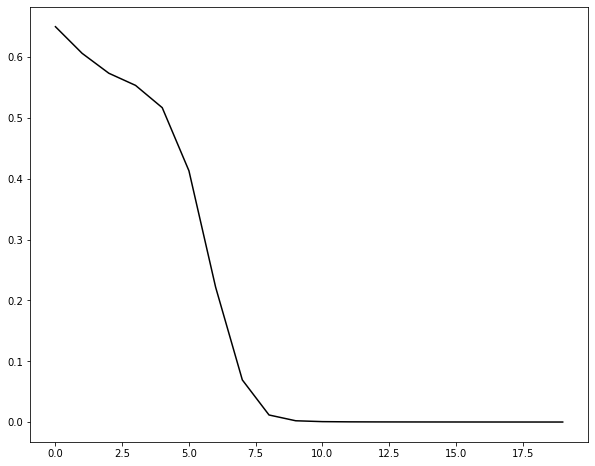

In [454]:
Y_train_onehot = tf.squeeze(tf.one_hot(tf.cast(Y_train, tf.int32), 2))
Y_train_onehot.shape

# X_train_padded = padding(X_train)
# Y_train_onehot_padded = padding(Y_train_onehot)

train_history = model.fit(x=X_train, y=Y_train_onehot, epochs=20, batch_size=10, verbose=0)

plt.plot(train_history.history['loss'], 'k')

#Model Testing

In [471]:
test_size = 100
X_test = tf.convert_to_tensor(np.random.choice([0,1], (test_size, width, height), p=[.5,.5]), tf.float32)

Y_test = true_ca(tf.convert_to_tensor(X_test, tf.float32))

X_test = X_test[..., tf.newaxis]
# X_test = tf.repeat(X_test, 2, 3)

Y_test = Y_test[..., tf.newaxis]
Y_test = tf.repeat(Y_test, 2, 3)
# Y_test.shape


# apparently model.evaluate is just broken on collab? take it to a dif platform and you get better results
eval = model.evaluate(X_test, Y_test)
print(eval)

4/4 [==============================] - 0s 5ms/step - loss: 3.7650 - accuracy: 0.6610
[3.7650179862976074, 0.6610000133514404]


Text(0.5, 1.0, 'Predicted Output')

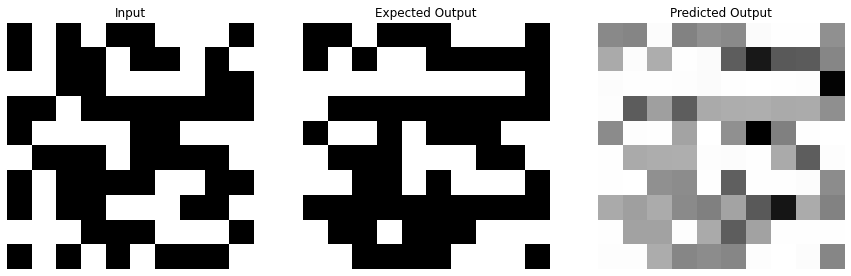

In [469]:
Y_pred = model.predict(X_test)[:,:,:,1]
index = 4

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(X_test[index][:,:,0])
plt.axis('off')
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(Y_test[index][:,:,0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(1,3,3)
plt.imshow(Y_pred[index])
plt.axis('off')
plt.title("Predicted Output")

Save the current model

In [451]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


Loading the best Saved model

In [465]:
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "model_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_95 (InputLayer)       [(None, 10, 10, 1)]       0         
                                                                 
 conv2d_136 (Conv2D)         (None, 10, 10, 10)        100       
                                                                 
 dense_254 (Dense)           (None, 10, 10, 10)        110       
                                                                 
 dense_255 (Dense)           (None, 10, 10, 10)        110       
                                                                 
 dense_256 (Dense)           (None, 10, 10, 2)         22        
                                                                 
Total params: 342
Trainable params: 342
Non-trainable params: 0
_________________________________________________________________


#Testing with a glider

Text(0.5, 1.0, 'Predicted Output')

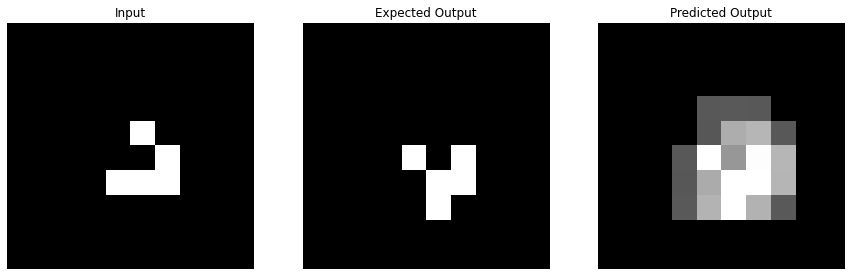

In [470]:
X_test = tf.convert_to_tensor(np.moveaxis(np.dstack([make_glider(10), make_glider(10)]), 2, 0), tf.float32)
Y_pred = model.predict(X_test)[:,:,:,1]

Y_test = true_ca(X_test)
X_test = X_test[..., tf.newaxis]
Y_test = Y_test[..., tf.newaxis]

index = 0

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(X_test[index][:,:,0])
plt.axis('off')
plt.title("Input")

plt.subplot(1,3,2)
plt.imshow(Y_test[index][:,:,0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(1,3,3)
plt.imshow(Y_pred[index])
plt.axis('off')
plt.title("Predicted Output")